---


## `Ensemble Models`

- In this notebook, we will give different weightage to the predictions of XGBOOST and CATBOOST and test whether the weighted average of models results will work or not.
- We will use final tuned parameters of XGBOOST and CATBOOST and use it to get the results.

---

In [1]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from catboost import CatBoostRegressor
from tqdm import tqdm
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error as msle

In [2]:
# read the dataset
data = pd.read_csv('final_data.csv')

In [3]:
# check for the null values
data.isna().sum().sum()

0

In [4]:
data.loc[0]

WEEK_END_DATE               2009-01-14
STORE_NUM                          367
UPC                         1111009477
BASE_PRICE                        1.57
FEATURE                              0
DISPLAY                              0
UNITS                               13
MANUFACTURER_1                       1
MANUFACTURER_2                       0
MANUFACTURER_3                       0
MANUFACTURER_4                       0
MANUFACTURER_5                       0
MANUFACTURER_6                       0
MANUFACTURER_7                       0
MANUFACTURER_8                       0
MANUFACTURER_9                       0
CATEGORY_1                           1
CATEGORY_2                           0
CATEGORY_3                           0
CATEGORY_4                           0
SUB_CATEGORY_1                       1
SUB_CATEGORY_2                       0
SUB_CATEGORY_3                       0
SUB_CATEGORY_4                       0
SUB_CATEGORY_5                       0
SUB_CATEGORY_6           

In [5]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [6]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [7]:
week = data.WEEK_END_DATE.unique()

---

***GET THE VALIDATION SETS***


---

In [8]:
# define the function to get the validation df
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [9]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,no_days_train_1,no_days_train_2,set_no,test_week,train_end_1,train_start_1,train_start_2,validate_week
0,56 days,56 days,set1,2011-09-28,2011-08-31,2011-07-13,2011-07-27,2011-09-14
1,56 days,56 days,set2,2011-09-21,2011-08-24,2011-07-06,2011-07-20,2011-09-07
2,56 days,56 days,set3,2011-09-14,2011-08-17,2011-06-29,2011-07-13,2011-08-31
3,56 days,56 days,set4,2011-09-07,2011-08-10,2011-06-22,2011-07-06,2011-08-24
4,56 days,56 days,set5,2011-08-31,2011-08-03,2011-06-15,2011-06-29,2011-08-17
5,56 days,56 days,set6,2011-08-24,2011-07-27,2011-06-08,2011-06-22,2011-08-10
6,56 days,56 days,set7,2011-08-17,2011-07-20,2011-06-01,2011-06-15,2011-08-03
7,56 days,56 days,set8,2011-08-10,2011-07-13,2011-05-25,2011-06-08,2011-07-27
8,56 days,56 days,set9,2011-08-03,2011-07-06,2011-05-18,2011-06-01,2011-07-20
9,56 days,56 days,set10,2011-07-27,2011-06-29,2011-05-11,2011-05-25,2011-07-13


In [10]:
# define the function to get the evaluation_set
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [11]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months=2,
                                                    no_of_validation=14))

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [12]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

---

***DEFINE THE XGBOOST MODEL***

---

In [15]:
model_XGB = xgb.XGBRegressor(n_estimators = 720,
                             subsample = 1,
                             max_depth = 4,
                             min_child_weight = 2,
                             gamma = 0,
                             learning_rate = 0.01,
                             n_jobs = 4,
                             random_state = 0,
                             objective ='reg:squarederror')

---

***READ THE CATBOOST DATA***

---

In [16]:
# read the data
catboost_data = pd.read_csv('catboost_data.csv')

In [17]:
# convert WEEK_END_DATE to datetime format
catboost_data.WEEK_END_DATE = pd.to_datetime(catboost_data.WEEK_END_DATE)

In [18]:
validation_df(catboost_data, week, no_of_months=2, no_of_validation=14)

,no_days_train_1,no_days_train_2,set_no,test_week,train_end_1,train_start_1,train_start_2,validate_week
0,56 days,56 days,set1,2011-09-28,2011-08-31,2011-07-13,2011-07-27,2011-09-14
1,56 days,56 days,set2,2011-09-21,2011-08-24,2011-07-06,2011-07-20,2011-09-07
2,56 days,56 days,set3,2011-09-14,2011-08-17,2011-06-29,2011-07-13,2011-08-31
3,56 days,56 days,set4,2011-09-07,2011-08-10,2011-06-22,2011-07-06,2011-08-24
4,56 days,56 days,set5,2011-08-31,2011-08-03,2011-06-15,2011-06-29,2011-08-17
5,56 days,56 days,set6,2011-08-24,2011-07-27,2011-06-08,2011-06-22,2011-08-10
6,56 days,56 days,set7,2011-08-17,2011-07-20,2011-06-01,2011-06-15,2011-08-03
7,56 days,56 days,set8,2011-08-10,2011-07-13,2011-05-25,2011-06-08,2011-07-27
8,56 days,56 days,set9,2011-08-03,2011-07-06,2011-05-18,2011-06-01,2011-07-20
9,56 days,56 days,set10,2011-07-27,2011-06-29,2011-05-11,2011-05-25,2011-07-13


In [19]:
# get the evaluation sets on catboost data
catboost_evaluation_set = get_evaluation_sets(catboost_data,
                                              validation_df(catboost_data,
                                                            week,
                                                            no_of_months=2,
                                                            no_of_validation=14))

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [20]:
# categorical feature indices
categorical_feature_indices = [1, 16, 17, 18, 19, 20, 21, 22, 23]

---

***DEFINE THE CATBOOST MODEL***

---

In [21]:
# define the catboost model
model_CBR = CatBoostRegressor(n_estimators=1800,
                              l2_leaf_reg=3,
                              max_depth=8,
                              learning_rate= 0.075,
                              objective='RMSE',
                              verbose=False,
                              eval_metric='MSLE',
                              cat_features=categorical_feature_indices)

In [22]:
# define the function to calculate the rmsle 
# we will modify the prediction by weights

# new_prediction = (prediction from model1)*weight + (prediction from model2)*(1 - weight)

def get_score(model_result1, model_result2, weight):
    
    true1, prediction1 = model_result1
    true2, prediction2 = model_result2
    prediction = prediction1*weight + prediction2*(1 - weight)
    return get_msle(true1, prediction)

# define the function get_ensemble score
# it will take the parameters as results of two models 
# it will use the get_score function to calculate the rmsle with weights value 0.05, 0.01,.... 1 

def get_ensemble_score(results_model1, results_model2) :
    
    train_1_model1, valid_model1 = results_model1
    
    train_1_model2, valid_model2 = results_model2
    
    model_result = []
    
    for weight in range(5,101,5):
        x = {}
        x['weight'] = weight/100
        x['train_1_result'] = get_score(train_1_model1, train_1_model2, weight/100)
        x['valid_result']   = get_score(valid_model1, valid_model2, weight/100)
    
        model_result.append(x)
        
        
    return model_result

# define the function to calculate the ensemble results on all the evaluation sets
# it will take 4 parameters
# eval_set =  evaluation sets for first model: xgboost
# eval_set_2 = evaluaiton sets for second model: catboost

# model1 = xgboost model object
# model2 = catboost mode object



def get_ensemble_results_on_evaluation_set(eval_set, eval_set_2, model1, model2):
    results = pd.DataFrame()
    set_n = 1
    for eval_data, eval_data_2 in tqdm(zip(eval_set,eval_set_2)):
        # use the evaluation set 1
        train_data_1, validate, train_data_2, test = eval_data
        
        # separate the target and independent variables on train and validate data
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']
        
        # fit the model1 : (xgboost) with the training data
        model_valid = model1.fit(train_data_1_x, train_data_1_y)
        
        # predict on train and valid
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
        
        
        
        # save prediction on train and valid
        results_model1 = ((train_data_1_y, predict_train_1),
                          (validate_y, predict_valid))
         
        
        ############################################################################
        
        # use the evaluation_Set 2
        train_data_1, validate, train_data_2, test = eval_data_2
        
        # separate the training and validation data
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']        
        
        # fit the model2 (catboost) with the training data
        model_valid = model2.fit(train_data_1_x, train_data_1_y)
        
        # predict on train and valid
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
        
        # save prediction on train and validation
        results_model2 = ((train_data_1_y, predict_train_1),
                          (validate_y, predict_valid))
        
        results = pd.concat([results,  
                             pd.pivot_table(pd.DataFrame.from_dict(get_ensemble_score(results_model1,
                                                                                      results_model2)),
                                            columns=['weight']).reset_index()])
        
        
        
    return results.groupby(['index']).mean().reset_index()
        

In [23]:
# calculate the ensemble results
ensemble_results = get_ensemble_results_on_evaluation_set(evaluation_sets, 
                                                          catboost_evaluation_set,
                                                          model_XGB, 
                                                          model_CBR)

14it [09:20, 38.97s/it]


In [29]:
ensemble_results

weight,index,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0,train_1_result,0.376398,0.376803,0.377358,0.378047,0.378860,0.379790,0.380830,0.381974,0.383219,...,0.385994,0.387518,0.389130,0.390827,0.392607,0.394469,0.396411,0.398432,0.400532,0.402709
1,valid_result,0.458889,0.457768,0.456917,0.456295,0.455874,0.455637,0.455569,0.455658,0.455896,...,0.456794,0.457442,0.458218,0.459119,0.460143,0.461287,0.462552,0.463937,0.465442,0.467068


In [24]:
updated = ensemble_results.pivot_table(columns=['index']).reset_index()

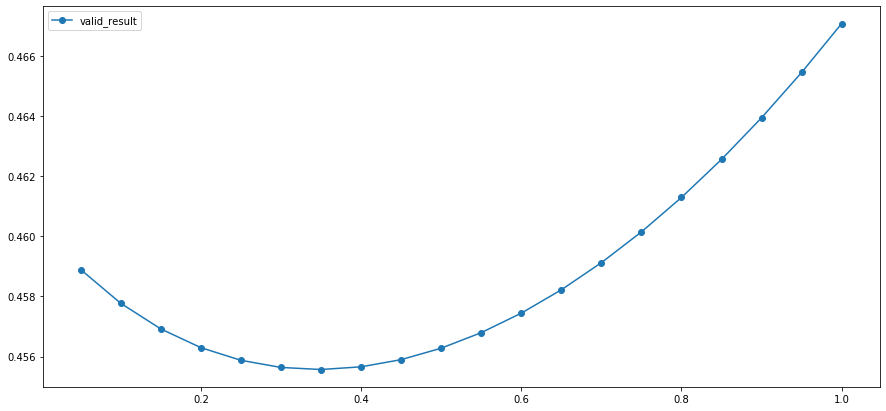

In [26]:
plt.figure(figsize=(15,7))
plt.plot(updated['weight'], updated['valid_result'], marker='o',label='valid_result')
plt.legend();

In [27]:
updated

index,weight,train_1_result,valid_result
0,0.05,0.376398,0.458889
1,0.10,0.376803,0.457768
2,0.15,0.377358,0.456917
3,0.20,0.378047,0.456295
4,0.25,0.378860,0.455874
5,0.30,0.379790,0.455637
6,0.35,0.380830,0.455569
7,0.40,0.381974,0.455658
8,0.45,0.383219,0.455896
9,0.50,0.384560,0.456277


---

So, by using `0.35*(XGBOOST Predictions) + 0.65*(CATBOOST Predicitons)` we are getting the best results.

---